# Outlier Analysis
The Density Field (DF) plots from all the catalogues of interest do not give any strong conclusive proof about the viability of one model over another. As a final shot before the Density Field analysis is abandoned, I check if any outlier trend can be found in the data. Finding a conclusive separation in the outlier halo DF analysis is interesting because that will imply that the extreme (outlier) halos from each catalogue do have a significant difference amongst themselves, and if found observationally, it might weakly explain the DLA problem.<br>
The idea is as follows-<br><br>
Of all the Halos of interest, I will find the ones which have a more than average DF in their surrounding. This analysis will happen in 2 ways.
<ol>
    <li>Choose the outliers on the basis of central peak DF and select the halos having the largest value for this.</li>
    <li>Define an average measure of DF over all the points available upto 10*R200b, and choose the ones having the largest value.</li>
</ol>
<br>
This analysis will be done for - 
<ol>
    <li>The one Halo which will have the largest measure in each case described above, from all the catalogues (2 plots for the above 2 methods)</li>
    <li>The top 5 percentile of Halos from each dataset having the largest measure, for both the 2 methods above (2 more plots from here)</li>
    <br>
</ol>
Another interesting problem to solve is to find at what percentile cut do we get a significant separation between the 3 methods. This problem will also be explored in this notebook


In [1]:
# All the required libraries are imported
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
from os import path

In [2]:
# Defining and loading important general data which will be used in the code later
colors=['g','b','r']
sourcePath="../SourceData/"  # Will not become a member of the git commits because CIC file is 1.1GB
fileNames=['b1','b1alpha','b1T10']
# Loading CIC data of density field. (512^3)
GridSize=512  # cubed of course.
cicSource="cic_snap049_grid512.dat"
data=np.reshape(np.fromfile(sourcePath+cicSource),(GridSize,GridSize,GridSize))

In [3]:
# This cell: Cosmology is defined. Simulation details are listed. Other constants to be used throughout are specified.
# Aseem's Cosmology
sigma_8=0.811
ns=0.961
h=0.7
Ob=0.045
Om=0.276

z=2.3         # Redshift specification
M_sun=1.989e+30  # M_sun in kg
Mega_parsec=3.086e+22  # parsec in metres
Delta=200.0   # Overdensity definition = Delta X background
rho_cr=((3*(100*h)**2)/(8*np.pi*6.673e-11))*((Mega_parsec/h**3)*1e+6/(M_sun/h))
# critical density of the Universe today 3H^2/8Pi*G in units M_sun.h^-1/(MPc.h^-1)^3
rho_m=Om*rho_cr # Units same as rho_cr. Don't need redshift considerations in comoving units i.e. Msun/h and MPc/h
del_crit=1.69
Lbox=150.0   # MPc/h

In [4]:
# Loading the given Halo catalogues from original non-pickled files to get ID's and positions
b1=np.loadtxt(sourcePath+'b1.txt')
b1alpha=np.loadtxt(sourcePath+'b1alpha.txt')
b1T10=np.loadtxt(sourcePath+'b1T10.txt')

b1ID,b1alphaID,b1T10ID=np.array(b1[:,0],dtype=int),np.array(b1alpha[:,0],dtype=int),np.array(b1T10[:,0],dtype=int)
b1Pos,b1alphaPos,b1T10Pos=[],[],[]

b1Pos.append(b1[:,1])
b1Pos.append(b1[:,2])
b1Pos.append(b1[:,3])
b1Pos=np.array(b1Pos)
b1Pos=b1Pos.T  # Holds the positions of all the b1 halos in order according to b1T10

b1alphaPos.append(b1alpha[:,1])
b1alphaPos.append(b1alpha[:,2])
b1alphaPos.append(b1alpha[:,3])
b1alphaPos=np.array(b1alphaPos)
b1alphaPos=b1alphaPos.T

b1T10Pos.append(b1T10[:,1])
b1T10Pos.append(b1T10[:,2])
b1T10Pos.append(b1T10[:,3])
b1T10Pos=np.array(b1T10Pos)
b1T10Pos=b1T10Pos.T

In [5]:
# The Master Catalogue contains a large amount of information about all the Halos from the simulations
# This need not be loaded if the pickle dumps have already been created for the ID to R200b mapping
# An automated check is integrated in this cell

mapPath=sourcePath+"IDtoR200b_Map/"   # Path where the halo maps are stored
b1Map,b1alphaMap,b1T10Map=[],[],[]    # Lists will store the halo maps

#----------------------------------------------------------------------------------------------------

# Returns an array of r200b for each ID passed as an argument, in order
# Note that treesMap is sorted on IDs and hence, we can run a Binary Search on it

def findR200b(ID):
    low,high=0,treesMap[:,0].size-1
    while(low<=high):
        mid=int(low+(high-low)/2)
        if(ID==treesMap[mid,0]):
            return(treesMap[mid,1])
        elif(ID>treesMap[mid,0]):
            low=mid+1
        else:
            high=mid-1
    return(-1)

#----------------------------------------------------------------------------------------------------

# If the Halo maps are not already computed, find them and store them for future use. Runs only once
def findHaloMaps():
    masterCat=np.loadtxt(sourcePath+"out_49.trees")

    treesID=np.array(masterCat[:,1],dtype=int)  # ID of halos in the master catalogue
    treesR200b=np.cbrt((masterCat[:,36]*3)/(4*np.pi*rho_m*200))   # The r200b of each halo from the master catalogue.
    treesMap=np.column_stack((treesID,treesR200b))
    treesMap=treesMap[treesMap[:,0].argsort()]   # TreesMap is a 2 column array with R200b for given ID of the halo
    # TreesMap is sorted wrt the ID column so that Binary Search can be done on it too save shitloads of time.
    
    # Storing a Map of Halo ID to the R200b for that ID as Pickle dumps in "../SourceData/IDtoR200b_Map/"
    # Run only once i.e. the first time. From then onwards directly load pickle dumps.
    b1R200b,b1alphaR200b,b1T10R200b=[],[],[]
    for i in b1ID:
        b1R200b.append(findR200b(i))
    for j in b1alphaID:
        b1alphaR200b.append(findR200b(j))
    for k in b1T10ID:
        b1T10R200b.append(findR200b(k))

    b1Map=np.array([b1ID,b1R200b]).T
    b1alphaMap=np.array([b1alphaID,b1alphaR200b]).T
    b1T10Map=np.array([b1T10ID,b1T10R200b]).T
    pickle.dump(b1Map,open(mapPath+"b1Map.p",'wb'))
    pickle.dump(b1alphaMap,open(mapPath+"b1alphaMap.p",'wb'))
    pickle.dump(b1T10Map,open(mapPath+"b1T10Map.p",'wb'))

#----------------------------------------------------------------------------------------------------

# The automated check to save unnecessary data loading and computations

if(all([path.exists(mapPath+"b1Map.p"),path.exists(mapPath+"b1alphaMap.p"),path.exists(mapPath+"b1T10Map.p")])):
    b1Map=pickle.load(open(mapPath+"b1Map.p",'rb'))
    b1alphaMap=pickle.load(open(mapPath+"b1alphaMap.p",'rb'))
    b1T10Map=pickle.load(open(mapPath+"b1T10Map.p",'rb'))
else:
    findHaloMaps()

In [6]:
# To query R200b's faster from the given maps. Arguments: which catalogue to find in, ID of the halo
# Returns the R200b os the halo with given ID from the given catalogue
def queryR200b(cat,ID):
    opt=np.array(fileNames)
    if not any(cat==opt):
        print('Please choose a correct catalogue. Catalogues available are: b1 | b1alpha | b1T10')
        return -1
    if cat=='b1':
        return float(b1Map[b1Map[:,0]==ID,1])
    if cat=='b1alpha':
        return float(b1alphaMap[b1alphaMap[:,0]==ID,1])
    if cat=='b1T10':
        return float(b1T10Map[b1T10Map[:,0]==ID,1])

Found the indices of largest centrally dense halos
Computed DF for all the 3 halos
Accomplished Successfully


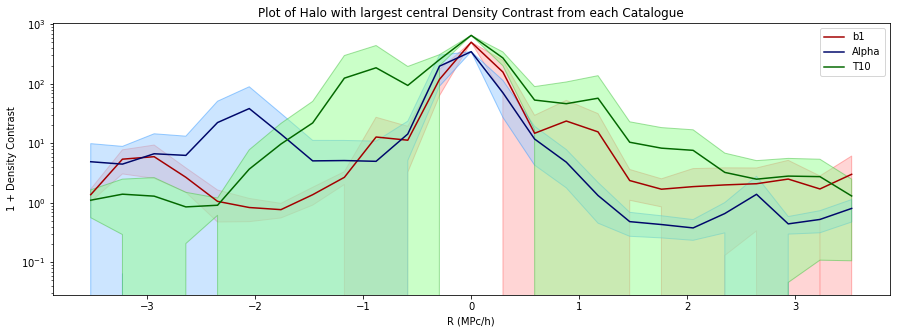

In [16]:
# -----------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------
# Method 1.1 - Find the halo with the largest central density from each dataset
# -----------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------
# A function that returns the index of the halo with largest central density
def largestIndex(pos):
    grid2box=Lbox/(GridSize-1)   # MPc/CICcell
    box2grid=(GridSize-1)/Lbox   # CICcells/MPc
    
    max_i=-1
    max_central=0.0
    for i in range(0,pos[:,0].size):
        p=pos[i]
        X=int(np.around(p[0]*box2grid))
        Y=int(np.around(p[1]*box2grid))
        Z=int(np.around(p[2]*box2grid))
        if data[X,Y,Z]>max_central:
            max_central=data[X,Y,Z]
            max_i=i
        
    return max_i
# -----------------------------------------------------------------------------------------

# Lambda functions to adjust for periodicity of the grid
periodicP=lambda d : d-GridSize if d>=GridSize else d
periodicN=lambda d : d+GridSize if d<0 else d
# -----------------------------------------------------------------------------------------

# Funtion to compute DF given the catalogue name, index of the halo and the maximum scale to reach out to
def findDF(cat,index,rlim):
    opt=np.array(fileNames)
    if not any(cat==opt):
        print('Please choose a correct catalogue. Catalogues available are: b1 | b1alpha | b1T10')
        return -1
    
    grid2box=Lbox/(GridSize-1)   # MPc/CICcell
    box2grid=(GridSize-1)/Lbox   # CICcells/MPc
    pos,df,df_std=np.array([]),np.array([]),np.array([])
    
    p=[]
    if cat=='b1':
        p=b1Pos[index]
    if cat=='b1alpha':
        p=b1alphaPos[index]
    if cat=='b1T10':
        p=b1T10Pos[index]
        
    X=int(np.around(p[0]*box2grid))
    Y=int(np.around(p[1]*box2grid))
    Z=int(np.around(p[2]*box2grid))
    pos=np.append(pos,0.0)
    df=np.append(df,data[X,Y,Z])
    df_std=np.append(df_std,0.0)

    scale_grid=1
    scale=scale_grid*grid2box
    while scale<=rlim:   # runs till real scale is less than  rlim. NOt we started from -rlim.
        pos=np.append(pos,scale)
        pos=np.concatenate(([-scale],pos))

        # Density contrast along all 6 directions
        prx=np.array([periodicP(X+scale_grid),Y,Z])
        plx=np.array([periodicN(X-scale_grid),Y,Z])
        pry=np.array([X,periodicP(Y+scale_grid),Z])
        ply=np.array([X,periodicN(Y-scale_grid),Z])
        prz=np.array([X,Y,periodicP(Z+scale_grid)])   
        plz=np.array([X,Y,periodicN(Z-scale_grid)])

        dfr=1.0+np.array([data[prx[0],prx[1],prx[2]],data[pry[0],pry[1],pry[2]],data[prz[0],prz[1],prz[2]]])
        dfl=1.0+np.array([data[plx[0],plx[1],plx[2]],data[ply[0],ply[1],ply[2]],data[plz[0],plz[1],plz[2]]])
        df_stdr,df_stdl=np.std(dfr),np.std(dfl)
        dfr,dfl=np.mean(dfr),np.mean(dfl)
    
        df,df_std=np.append(df,dfr),np.append(df_std,df_stdr)
        df,df_std=np.concatenate(([dfl],df)),np.concatenate(([df_stdl],df_std))

        scale_grid+=1
        scale=scale_grid*grid2box
    return pos,df,df_std
# -----------------------------------------------------------------------------------------
        
# Function that implements the method 1.1 
def outlier_11():
    max_index=[-1,-1,-1]  #store the index of the halo with largest central density
    max_index[0],max_index[1],max_index[2]=largestIndex(b1Pos),largestIndex(b1alphaPos),largestIndex(b1T10Pos)
    print('Found the indices of largest centrally dense halos')
    max_R200b=np.amax(np.array([queryR200b('b1',b1ID[max_index[0]]),
                                queryR200b('b1alpha',b1alphaID[max_index[1]]),
                                queryR200b('b1T10',b1T10ID[max_index[2]])
                               ]))  # To store the largest R200b of the 3 Halos
    max_R200b*=10.0
    b1_p,b1_DF,b1_std=findDF('b1',max_index[0],max_R200b)
    b1alpha_p,b1alpha_DF,b1alpha_std=findDF('b1alpha',max_index[1],max_R200b)
    b1T10_p,b1T10_DF,b1T10_std=findDF('b1T10',max_index[2],max_R200b)
    print('Computed DF for all the 3 halos')
    
    # Plotting everything below
    plt.figure(num=1,figsize=(15,5))
    plt.title('Plot of Halo with largest central Density Contrast from each Catalogue')
    plt.plot(b1_p, b1_DF, 'k', color='#A30000',label="b1")
    plt.fill_between(b1_p, b1_DF+b1_std, b1_DF-b1_std, alpha=0.5, edgecolor='#FF6B6B', facecolor='#FFADAD')
    plt.plot(b1alpha_p, b1alpha_DF, 'k', color='#00086B',label="Alpha")
    plt.fill_between(b1alpha_p, b1alpha_DF+b1alpha_std, b1alpha_DF-b1alpha_std, alpha=0.5, edgecolor='#3a9cff', facecolor='#9bcdff')
    plt.plot(b1T10_p, b1T10_DF, 'k', color='#036800',label="T10")
    plt.fill_between(b1T10_p, b1T10_DF+b1T10_std, b1T10_DF-b1T10_std, alpha=0.5, edgecolor='#49c145', facecolor='#96ff93')
    plt.xlabel('R (MPc/h)')
    plt.ylabel('1 + Density Contrast')
    plt.yscale('log')
    plt.legend()
    plt.savefig('./Output/outlier_analysis/method11_centralLargestHalo',bbox_inches='tight')
    print('Accomplished Successfully')
    
outlier_11()

In [ ]:
# The LOS Method implemented has lines always passing parallel to x-axis and through the grid points
# Direction specifies which direction the LOS are parallel to
# r_lim specifies the limit to which LOS calculations should be done about the central position of the halo
# Limit is specified as distance in the real position coordinates
# Also presenting the linear density around the halo of interest

def simpleR200bLOS(halo,r200b,rlim,direction='x'):
    pos,df=np.array([]),np.array([])
    rlim=rlim*r200b  # the upper limit to which Density Field should be found
    
    grid2box=Lbox/(GridSize-1)   # MPc/CICcell
    box2grid=(GridSize-1)/Lbox   # CICcells/MPc
    
    # Connvert Halo co-odinates from real space to closest CIC Grid positions
    # Possible issue here. Experiment with floor, ceil and around
    #X=int(np.ceil(halo[0]*box2grid))
    #Y=int(np.ceil(halo[1]*box2grid))
    #Z=int(np.ceil(halo[2]*box2grid))
    
    X=int(np.floor(halo[0]*box2grid))
    Y=int(np.floor(halo[1]*box2grid))
    Z=int(np.floor(halo[2]*box2grid))
    
    #X=int(np.around(halo[0]*box2grid))
    #Y=int(np.around(halo[1]*box2grid))
    #Z=int(np.around(halo[2]*box2grid))
    
    # Initial values directly appended
    pos=np.append(pos,0.0)
    df=np.append(df,data[X,Y,Z])
    
    # Appending to front and back of the DF array iteratively, starting from center to make sure center is def included
    scale_grid=1
    scale=scale_grid*grid2box
    while scale<=rlim:   # runs till real scale is less than  rlim. NOt we started from -rlim.
        pos=np.append(pos,scale/r200b)
        pos=np.concatenate(([-scale/r200b],pos))
        
        pr,pl=[],[]
        if direction=='x':
            pr=np.array([X+scale_grid,Y,Z])
            pl=np.array([X-scale_grid,Y,Z])
        elif direction=='y':
            pr=np.array([X,Y+scale_grid,Z])
            pl=np.array([X,Y-scale_grid,Z])
        elif direction=='z':
            pr=np.array([X,Y,Z+scale_grid])   
            pl=np.array([X,Y,Z-scale_grid])   
        else:
            print("Please choose a valid direction for the LOS. Valid choices are - x | y | z")
            exit()
            
        pr[pr>=GridSize]=pr[pr>=GridSize]-GridSize
        pr[pr<0]=pr[pr<0]+GridSize   # periodicty of the box considered
        df=np.append(df,data[pr[0],pr[1],pr[2]])
        
        pl[pl>=GridSize]=pl[pl>=GridSize]-GridSize
        pl[pl<0]=pl[pl<0]+GridSize   # periodicty of the box considered
        
        df=np.concatenate(([data[pl[0],pl[1],pl[2]]],df))
        
        scale_grid+=1
        scale=scale_grid*grid2box
        
    return np.array(pos),np.array(df)

In [ ]:
# LOS method implemented has lines passing through every halo of each catalogue to give a statistically robust estimate
# Arguments to be passed are halo IDs and corresponding positions, rlim_*R200b limit out to which compute DF...
# ...how many directions to consider for calculating the LOS - all | x | y | z
def averagedLOS_R200b(cat,rlim_,los_direction='all'):
    
    cat_opts=np.array(['b1','b1alpha','b1T10'])
    if not any(cat_opts==cat):
        print("Please enter a valid catalogue option, Valid arguments are: b1 | b1alpha | b1T10")
        return
    
    dir_opts=np.array(['all','x','y','z'])
    if not any(dir_opts == los_direction):
        print("Please enter a valid value to direction argument. Valid values -- all | x | y | z")
        return
    
    mocks,ID=[],[]
    if cat=='b1':
        mocks=b1Pos
        ID=b1ID
    if cat=='b1alpha':
        mocks=b1alphaPos
        ID=b1alphaID
    if cat=='b1T10':
        mocks=b1T10Pos
        ID=b1T10ID
    print('Secured Catalogue Data')
    print(mocks.shape,ID.shape)
    
    masterPos,masterDF=[],[]
    # masterDF will store LOS DF for each halo in mocks
    # resultDF will be the mean of masterDF at each scale
    
    if los_direction == 'all':
        for h in range(0,mocks[:,0].size):
            for directn in ['x','y','z']:
                scales,df=simpleR200bLOS(mocks[h],queryR200b(cat,ID[h]),rlim_,directn)
                masterDF.append(df)
                masterPos.append(scales)
        
    else:
        for h in range(0,mocks[:,0].size):
            scales,df=simpleR200bLOS(mocks[h],queryR200b(cat,ID[h]),rlim_,los_direction)
            masterDF.append(df)
            masterPos.append(scales)
    
    # ---------------------------------------------------------------------------------------------------------------
    # No 2 halos have the same R200b values, hence, all the DF values at R/R200b scales are found at different...
    #... non-matching scales. Due to this statistics can't be run on these points because we don't have DF values at...
    #... a single R/R200b.
    # 2 solutions to these are to either make bins or do an interpolation
    # Issue with bins is that the mean spacing of R/R200b between two neighboring points is too large and we can fit...
    #... only about 3-4 bins on one side of the Halo of interest.
    # Issue with interpolation is that the number of points to interpolate between is also very small, evidently,...
    #... the interpolation is not expected to be very robust
    
    # customStats() takes a go at both the methods by specifying in the mode which can take 2 values- 'bin','interp'
    # ---------------------------------------------------------------------------------------------------------------
    
   
    #resultDF,std_up,std_below=customStats(masterPos,masterDF,mode='std') # mode='std' | mode='percentile'
    masterPos,resultDF,prcntile16,prcntile84=customStats(masterPos,masterDF,'interp',rlim_)
    
    if len(masterPos)==len(resultDF):
        #return masterPos,resultDF,std_up,std_below
        return masterPos,resultDF,prcntile16,prcntile84
    else:
        print("Fatal error. Pos and DF sizes don't match.")
        return
    #return masterPos,masterDF